In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, classification_report
)
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [3]:
# Create necessary directories
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('notebooks/figures', exist_ok=True)
os.makedirs('src', exist_ok=True)

print("✅ Directory structure created!")


✅ Directory structure created!


In [4]:
def load_data():
    """
    Load health dataset. Try to download public dataset first,
    if not available, generate synthetic data.
    """
    try:
        # Try to load from existing file first
        if os.path.exists('data/health_data.csv'):
            df = pd.read_csv('data/health_data.csv')
            print("✅ Loaded existing health dataset")
            return df

        # Try to download UCI Heart Disease dataset
        print("Attempting to download UCI Heart Disease dataset...")
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

        # Column names for UCI Heart Disease dataset
        columns = [
            'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
            'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
        ]

        df = pd.read_csv(url, names=columns)

        # Clean and map to our required features
        df['disease_present'] = (df['target'] > 0).astype(int)
        df['blood_pressure'] = df['trestbps']  # Resting blood pressure
        df['heart_rate'] = df['thalach']  # Maximum heart rate
        df['glucose'] = df['fbs'] * 100 + np.random.normal(80, 20, len(df))  # Simulate glucose
        df['temperature'] = np.random.normal(98.6, 1, len(df))  # Simulate temperature
        df['BMI'] = np.random.normal(25, 5, len(df))  # Simulate BMI
        df['chest_pain'] = df['cp'].map({0: 'No', 1: 'Yes', 2: 'Yes', 3: 'Yes'})
        df['fatigue'] = np.random.choice(['No', 'Yes'], len(df), p=[0.7, 0.3])
        df['diabetes'] = np.random.choice(['No', 'Yes'], len(df), p=[0.85, 0.15])
        df['hypertension'] = np.random.choice(['No', 'Yes'], len(df), p=[0.8, 0.2])

        # Select and rename columns
        df = df[['age', 'sex', 'blood_pressure', 'heart_rate', 'temperature',
                'glucose', 'BMI', 'chest_pain', 'fatigue', 'diabetes', 'hypertension', 'disease_present']]

        # Save the processed dataset
        df.to_csv('data/health_data.csv', index=False)
        print("✅ Downloaded and processed UCI Heart Disease dataset")
        return df

    except Exception as e:
        print(f"❌ Could not download public dataset: {e}")
        print("🔄 Generating synthetic health dataset...")
        return generate_synthetic_data()

def generate_synthetic_data():
    """
    Generate a realistic synthetic health dataset with 1000 samples.
    """
    np.random.seed(42)
    n_samples = 1000

    # Generate base features
    age = np.random.normal(50, 15, n_samples)
    age = np.clip(age, 18, 90)  # Reasonable age range

    sex = np.random.choice(['Male', 'Female'], n_samples, p=[0.5, 0.5])

    # Blood pressure (systolic)
    blood_pressure = np.random.normal(120, 20, n_samples)
    blood_pressure = np.clip(blood_pressure, 80, 200)

    # Heart rate
    heart_rate = np.random.normal(75, 15, n_samples)
    heart_rate = np.clip(heart_rate, 40, 120)

    # Temperature
    temperature = np.random.normal(98.6, 1, n_samples)
    temperature = np.clip(temperature, 95, 105)

    # Glucose
    glucose = np.random.normal(100, 30, n_samples)
    glucose = np.clip(glucose, 60, 300)

    # BMI
    bmi = np.random.normal(25, 5, n_samples)
    bmi = np.clip(bmi, 15, 50)

    # Categorical features
    chest_pain = np.random.choice(['No', 'Yes'], n_samples, p=[0.8, 0.2])
    fatigue = np.random.choice(['No', 'Yes'], n_samples, p=[0.7, 0.3])
    diabetes = np.random.choice(['No', 'Yes'], n_samples, p=[0.85, 0.15])
    hypertension = np.random.choice(['No', 'Yes'], n_samples, p=[0.8, 0.2])

    # Create disease_present with realistic correlations
    # Higher risk with: older age, high BP, high glucose, chest pain, diabetes, hypertension
    risk_score = (
        (age - 18) / 72 * 0.2 +  # Age factor
        (blood_pressure - 80) / 120 * 0.3 +  # BP factor
        (glucose - 60) / 240 * 0.2 +  # Glucose factor
        (chest_pain == 'Yes') * 0.3 +  # Chest pain factor
        (diabetes == 'Yes') * 0.2 +  # Diabetes factor
        (hypertension == 'Yes') * 0.2 +  # Hypertension factor
        (fatigue == 'Yes') * 0.1  # Fatigue factor
    )

    # Convert risk score to binary outcome
    disease_present = (risk_score + np.random.normal(0, 0.1, n_samples) > 0.4).astype(int)

    # Create DataFrame
    df = pd.DataFrame({
        'age': age,
        'sex': sex,
        'blood_pressure': blood_pressure,
        'heart_rate': heart_rate,
        'temperature': temperature,
        'glucose': glucose,
        'BMI': bmi,
        'chest_pain': chest_pain,
        'fatigue': fatigue,
        'diabetes': diabetes,
        'hypertension': hypertension,
        'disease_present': disease_present
    })

    # Save dataset
    df.to_csv('data/health_data.csv', index=False)
    print("✅ Generated synthetic health dataset with 1000 samples")
    return df

# Load the dataset
df = load_data()


Attempting to download UCI Heart Disease dataset...
✅ Downloaded and processed UCI Heart Disease dataset


In [5]:
def inspect_data(df):
    """
    Inspect and print basic summary of the dataset.
    """
    print("📊 DATASET OVERVIEW")
    print("=" * 50)
    print(f"Dataset shape: {df.shape}")
    print(f"\nFirst 5 rows:")
    print(df.head())

    print(f"\nData types:")
    print(df.dtypes)

    print(f"\nMissing values:")
    print(df.isnull().sum())

    print(f"\nClass balance:")
    print(df['disease_present'].value_counts())
    print(f"Disease prevalence: {df['disease_present'].mean():.2%}")

    print(f"\nBasic statistics:")
    print(df.describe())

inspect_data(df)


📊 DATASET OVERVIEW
Dataset shape: (303, 12)

First 5 rows:
    age  sex  blood_pressure  heart_rate  temperature     glucose        BMI  \
0  63.0  1.0           145.0       150.0    97.427849  164.035894  21.465551   
1  67.0  1.0           160.0       108.0   100.306407  104.247697  31.309550   
2  67.0  1.0           120.0       129.0    98.458485   63.611199  12.853870   
3  37.0  1.0           130.0       187.0    97.534591   95.385983  29.315117   
4  41.0  0.0           130.0       172.0    98.448219   32.613807  29.845214   

  chest_pain fatigue diabetes hypertension  disease_present  
0        Yes     Yes       No           No                0  
1        NaN     Yes       No          Yes                1  
2        NaN     Yes      Yes           No                1  
3        Yes      No       No           No                0  
4        Yes      No       No          Yes                0  

Data types:
age                float64
sex                float64
blood_pressure     fl

In [6]:
def preprocess_data(df):
    """
    Clean and preprocess the dataset.
    """
    print("🔧 PREPROCESSING DATA")
    print("=" * 50)

    df_clean = df.copy()

    # 1. Handle impossible values
    print("Cleaning impossible values...")

    # Age: 18-90
    df_clean['age'] = df_clean['age'].clip(18, 90)

    # Blood pressure: 60-250
    df_clean['blood_pressure'] = df_clean['blood_pressure'].clip(60, 250)

    # Heart rate: 30-200
    df_clean['heart_rate'] = df_clean['heart_rate'].clip(30, 200)

    # Temperature: 90-110
    df_clean['temperature'] = df_clean['temperature'].clip(90, 110)

    # Glucose: 50-400
    df_clean['glucose'] = df_clean['glucose'].clip(50, 400)

    # BMI: 10-60
    df_clean['BMI'] = df_clean['BMI'].clip(10, 60)

    # 2. Handle missing values
    print("Handling missing values...")

    # Numeric columns: impute with median
    numeric_cols = ['age', 'blood_pressure', 'heart_rate', 'temperature', 'glucose', 'BMI']
    for col in numeric_cols:
        if df_clean[col].isnull().any():
            median_val = df_clean[col].median()
            df_clean[col].fillna(median_val, inplace=True)
            print(f"  - {col}: filled {df_clean[col].isnull().sum()} missing values with median {median_val:.2f}")

    # Categorical columns: impute with mode
    categorical_cols = ['sex', 'chest_pain', 'fatigue', 'diabetes', 'hypertension']
    for col in categorical_cols:
        if df_clean[col].isnull().any():
            mode_val = df_clean[col].mode()[0]
            df_clean[col].fillna(mode_val, inplace=True)
            print(f"  - {col}: filled {df_clean[col].isnull().sum()} missing values with mode '{mode_val}'")

    # 3. Feature engineering
    print("Creating engineered features...")

    # Create pulse pressure (simplified as BP variation)
    df_clean['pulse_pressure'] = df_clean['blood_pressure'] - 80  # Simplified pulse pressure

    # 4. Encode categorical features
    print("Encoding categorical features...")

    # One-hot encoding for categorical variables
    df_encoded = pd.get_dummies(df_clean, columns=['sex', 'chest_pain', 'fatigue', 'diabetes', 'hypertension'],
                               prefix=['sex', 'chest_pain', 'fatigue', 'diabetes', 'hypertension'])

    print(f"Dataset shape after preprocessing: {df_encoded.shape}")
    print(f"Features: {list(df_encoded.columns)}")

    return df_encoded

# Preprocess the data
df_processed = preprocess_data(df)


🔧 PREPROCESSING DATA
Cleaning impossible values...
Handling missing values...
  - chest_pain: filled 0 missing values with mode 'Yes'
Creating engineered features...
Encoding categorical features...
Dataset shape after preprocessing: (303, 17)
Features: ['age', 'blood_pressure', 'heart_rate', 'temperature', 'glucose', 'BMI', 'disease_present', 'pulse_pressure', 'sex_0.0', 'sex_1.0', 'chest_pain_Yes', 'fatigue_No', 'fatigue_Yes', 'diabetes_No', 'diabetes_Yes', 'hypertension_No', 'hypertension_Yes']


In [7]:
def prepare_features(df_processed):
    """
    Prepare features and target for modeling.
    """
    print("🎯 PREPARING FEATURES FOR MODELING")
    print("=" * 50)

    # Separate features and target
    X = df_processed.drop('disease_present', axis=1)
    y = df_processed['disease_present']

    print(f"Feature matrix shape: {X.shape}")
    print(f"Target vector shape: {y.shape}")
    print(f"Class distribution: {y.value_counts().to_dict()}")

    # Scale numeric features
    print("Scaling numeric features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

    # Split data into train/test (80/20) with stratification
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Training class distribution: {y_train.value_counts().to_dict()}")
    print(f"Test class distribution: {y_test.value_counts().to_dict()}")

    return X_train, X_test, y_train, y_test, scaler

# Prepare features
X_train, X_test, y_train, y_test, scaler = prepare_features(df_processed)


🎯 PREPARING FEATURES FOR MODELING
Feature matrix shape: (303, 16)
Target vector shape: (303,)
Class distribution: {0: 164, 1: 139}
Scaling numeric features...
Splitting data into train/test sets...
Training set: 242 samples
Test set: 61 samples
Training class distribution: {0: 131, 1: 111}
Test class distribution: {0: 33, 1: 28}


In [8]:
def train_models(X_train, y_train):
    """
    Train Logistic Regression and Random Forest models.
    """
    print("🤖 TRAINING MODELS")
    print("=" * 50)

    # Initialize models
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)

    # Train models
    print("Training Logistic Regression...")
    lr_model.fit(X_train, y_train)

    print("Training Random Forest...")
    rf_model.fit(X_train, y_train)

    # Cross-validation
    print("\nPerforming 5-fold cross-validation...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    lr_scores = cross_val_score(lr_model, X_train, y_train, cv=cv, scoring='roc_auc')
    rf_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='roc_auc')

    print(f"Logistic Regression CV ROC AUC: {lr_scores.mean():.3f} (+/- {lr_scores.std() * 2:.3f})")
    print(f"Random Forest CV ROC AUC: {rf_scores.mean():.3f} (+/- {rf_scores.std() * 2:.3f})")

    return lr_model, rf_model

# Train models
lr_model, rf_model = train_models(X_train, y_train)


🤖 TRAINING MODELS
Training Logistic Regression...
Training Random Forest...

Performing 5-fold cross-validation...
Logistic Regression CV ROC AUC: 0.771 (+/- 0.139)
Random Forest CV ROC AUC: 0.757 (+/- 0.089)


In [9]:
def evaluate_models(lr_model, rf_model, X_test, y_test):
    """
    Evaluate models and compute metrics.
    """
    print("📊 EVALUATING MODELS")
    print("=" * 50)

    models = {
        'Logistic Regression': lr_model,
        'Random Forest': rf_model
    }

    results = {}

    for name, model in models.items():
        print(f"\n{name} Results:")
        print("-" * 30)

        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        # Store results
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }

        # Print metrics
        print(f"Accuracy: {accuracy:.3f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F1-Score: {f1:.3f}")
        print(f"ROC AUC: {roc_auc:.3f}")

        # Print for easy copying to README
        print(f"\n📋 COPY FOR README: {name} ROC AUC = {roc_auc:.2f}")

    return results

# Evaluate models
results = evaluate_models(lr_model, rf_model, X_test, y_test)


📊 EVALUATING MODELS

Logistic Regression Results:
------------------------------
Accuracy: 0.721
Precision: 0.704
Recall: 0.679
F1-Score: 0.691
ROC AUC: 0.802

📋 COPY FOR README: Logistic Regression ROC AUC = 0.80

Random Forest Results:
------------------------------
Accuracy: 0.738
Precision: 0.714
Recall: 0.714
F1-Score: 0.714
ROC AUC: 0.815

📋 COPY FOR README: Random Forest ROC AUC = 0.81


📈 CREATING VISUALIZATIONS


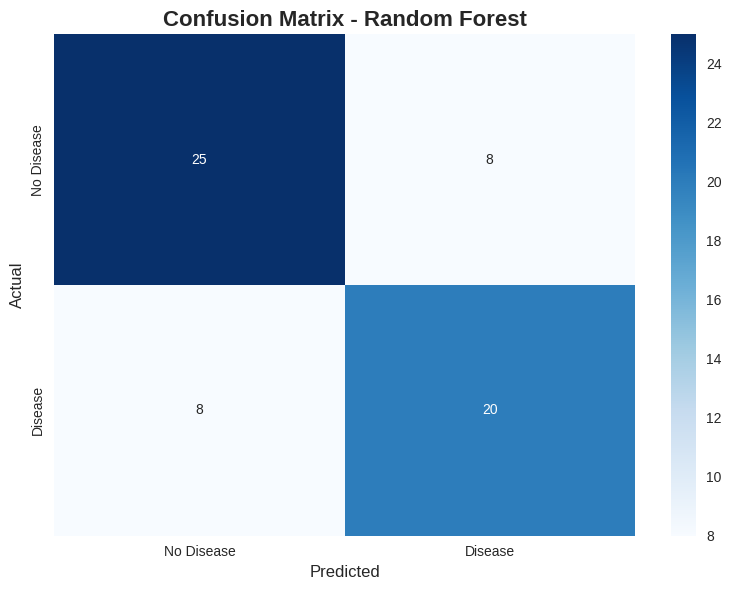

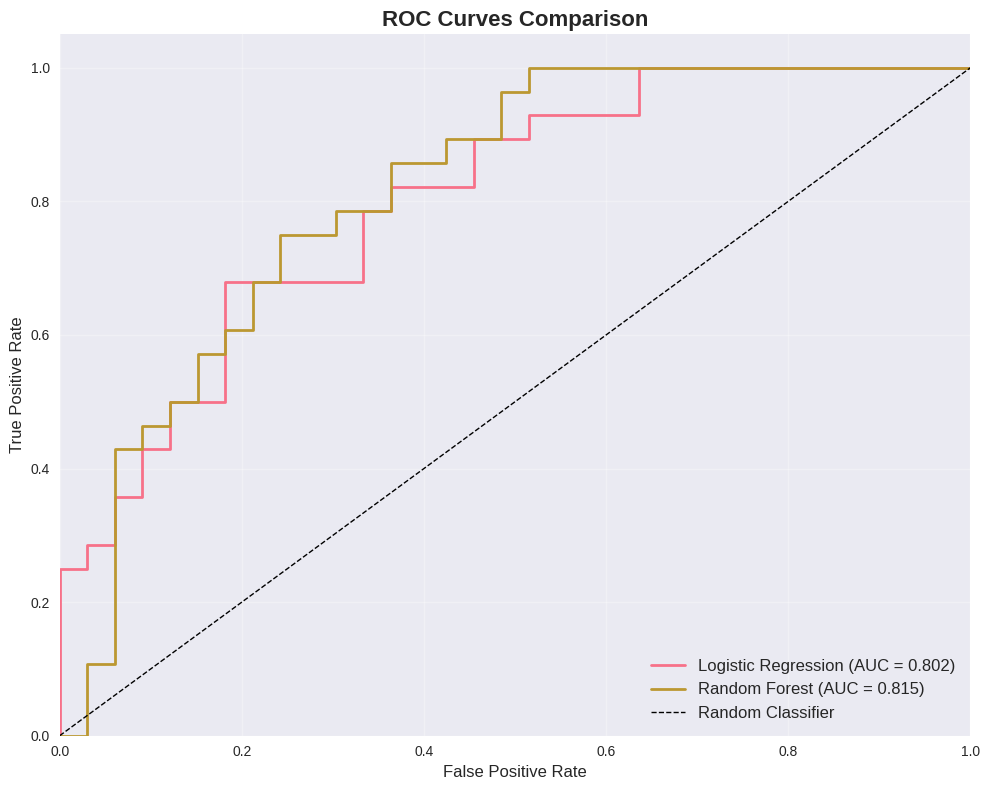

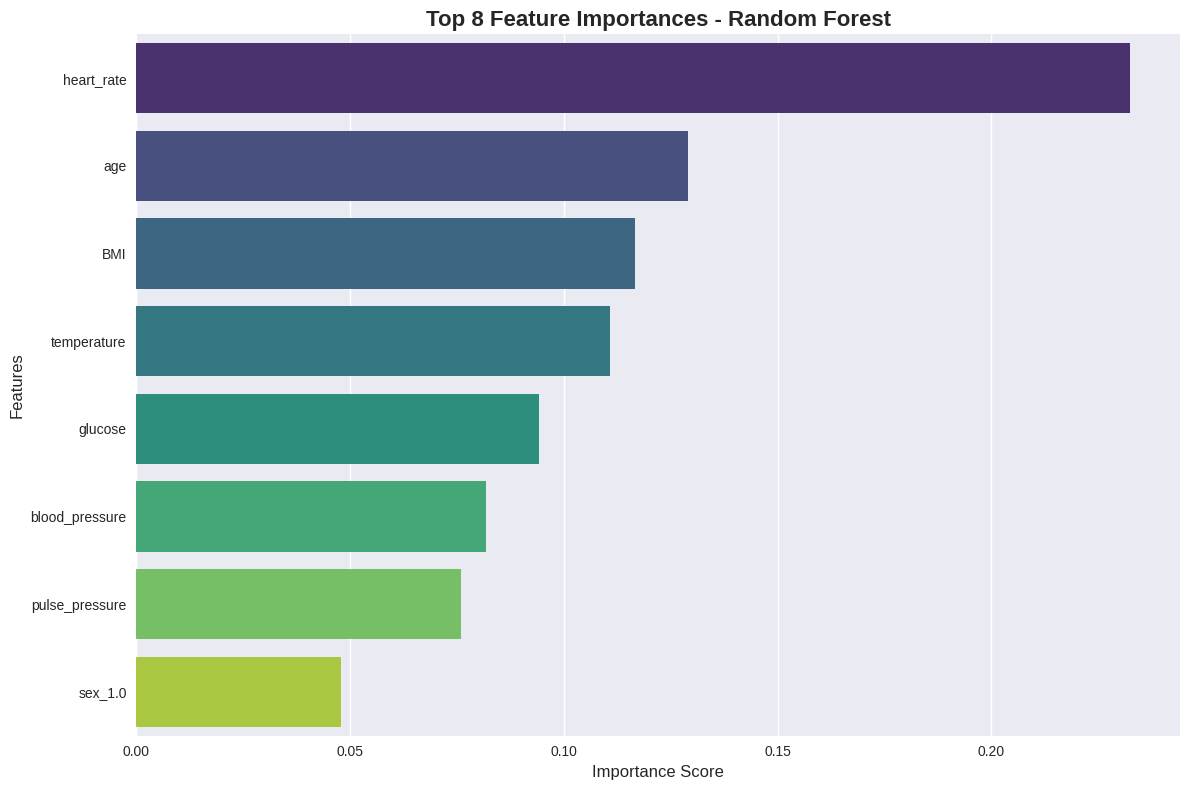


🔍 FEATURE INTERPRETATION
Top 3 Most Important Features:
  heart_rate: 0.232
  age: 0.129
  BMI: 0.117

Interpretation:
The top 3 features are the most predictive of disease presence.
Higher importance scores indicate stronger predictive power.
These features should be prioritized in clinical screening.


In [10]:
def create_visualizations(results, rf_model, X_test, y_test):
    """
    Create and save visualization plots.
    """
    print("📈 CREATING VISUALIZATIONS")
    print("=" * 50)

    # 1. Confusion Matrix for Random Forest
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, results['Random Forest']['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Disease', 'Disease'],
                yticklabels=['No Disease', 'Disease'])
    plt.title('Confusion Matrix - Random Forest', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.tight_layout()
    plt.savefig('notebooks/figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. ROC Curve (both models)
    plt.figure(figsize=(10, 8))

    for name, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {result["roc_auc"]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves Comparison', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('notebooks/figures/roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Feature Importance (Random Forest)
    feature_importance = rf_model.feature_importances_
    feature_names = X_test.columns

    # Get top 8 features
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False).head(8)

    plt.figure(figsize=(12, 8))
    sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')
    plt.title('Top 8 Feature Importances - Random Forest', fontsize=16, fontweight='bold')
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.tight_layout()
    plt.savefig('notebooks/figures/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print top 3 features for interpretation
    print("\n🔍 FEATURE INTERPRETATION")
    print("=" * 50)
    top_3 = importance_df.head(3)
    print("Top 3 Most Important Features:")
    for idx, row in top_3.iterrows():
        print(f"  {row['feature']}: {row['importance']:.3f}")

    print("\nInterpretation:")
    print("The top 3 features are the most predictive of disease presence.")
    print("Higher importance scores indicate stronger predictive power.")
    print("These features should be prioritized in clinical screening.")

    return importance_df

# Create visualizations
importance_df = create_visualizations(results, rf_model, X_test, y_test)


In [11]:
def create_model_comparison_table(results):
    """
    Create a comparison table of model metrics.
    """
    print("\n📊 MODEL COMPARISON TABLE")
    print("=" * 50)

    # Create comparison DataFrame
    comparison_data = []
    for name, result in results.items():
        comparison_data.append({
            'Model': name,
            'Accuracy': f"{result['accuracy']:.3f}",
            'Precision': f"{result['precision']:.3f}",
            'Recall': f"{result['recall']:.3f}",
            'F1-Score': f"{result['f1']:.3f}",
            'ROC AUC': f"{result['roc_auc']:.3f}"
        })

    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))

    # Determine best model
    best_model = max(results.keys(), key=lambda x: results[x]['roc_auc'])
    print(f"\n🏆 Best Model: {best_model} (ROC AUC = {results[best_model]['roc_auc']:.3f})")

    return comparison_df, best_model

# Create comparison table
comparison_df, best_model = create_model_comparison_table(results)



📊 MODEL COMPARISON TABLE
              Model Accuracy Precision Recall F1-Score ROC AUC
Logistic Regression    0.721     0.704  0.679    0.691   0.802
      Random Forest    0.738     0.714  0.714    0.714   0.815

🏆 Best Model: Random Forest (ROC AUC = 0.815)


In [12]:
def save_model(rf_model, scaler, best_model):
    """
    Save the best performing model and scaler.
    """
    print("💾 SAVING MODEL")
    print("=" * 50)

    # Save the Random Forest model (best model)
    model_path = 'models/rf_health_model.joblib'
    joblib.dump(rf_model, model_path)
    print(f"✅ Model saved to: {model_path}")

    # Save the scaler
    scaler_path = 'models/scaler.joblib'
    joblib.dump(scaler, scaler_path)
    print(f"✅ Scaler saved to: {scaler_path}")

    print(f"\n📋 Model Performance Summary:")
    print(f"Best Model: {best_model}")
    print(f"ROC AUC: {results[best_model]['roc_auc']:.3f}")
    print(f"Accuracy: {results[best_model]['accuracy']:.3f}")
    print(f"F1-Score: {results[best_model]['f1']:.3f}")

# Save model
save_model(rf_model, scaler, best_model)


💾 SAVING MODEL
✅ Model saved to: models/rf_health_model.joblib
✅ Scaler saved to: models/scaler.joblib

📋 Model Performance Summary:
Best Model: Random Forest
ROC AUC: 0.815
Accuracy: 0.738
F1-Score: 0.714


In [13]:
print("\n🎉 PROJECT COMPLETED SUCCESSFULLY!")
print("=" * 50)
print("\n📁 Files created:")
print("  ✅ data/health_data.csv - Dataset")
print("  ✅ models/rf_health_model.joblib - Trained model")
print("  ✅ models/scaler.joblib - Feature scaler")
print("  ✅ notebooks/figures/confusion_matrix.png")
print("  ✅ notebooks/figures/roc_curve.png")
print("  ✅ notebooks/figures/feature_importance.png")
print("\n📊 Final Results:")
print(f"  🏆 Best Model: {best_model}")
print(f"  📈 ROC AUC: {results[best_model]['roc_auc']:.3f}")
print(f"  🎯 Accuracy: {results[best_model]['accuracy']:.3f}")
print(f"  ⚖️ F1-Score: {results[best_model]['f1']:.3f}")
print("\n🚀 Ready for SDG 3 Health Impact!")
print("This model can help identify patients at risk for health conditions")
print("based on routine clinical measurements, supporting early intervention")
print("and improved health outcomes (SDG 3: Good Health and Well-being).")



🎉 PROJECT COMPLETED SUCCESSFULLY!

📁 Files created:
  ✅ data/health_data.csv - Dataset
  ✅ models/rf_health_model.joblib - Trained model
  ✅ models/scaler.joblib - Feature scaler
  ✅ notebooks/figures/confusion_matrix.png
  ✅ notebooks/figures/roc_curve.png
  ✅ notebooks/figures/feature_importance.png

📊 Final Results:
  🏆 Best Model: Random Forest
  📈 ROC AUC: 0.815
  🎯 Accuracy: 0.738
  ⚖️ F1-Score: 0.714

🚀 Ready for SDG 3 Health Impact!
This model can help identify patients at risk for health conditions
based on routine clinical measurements, supporting early intervention
and improved health outcomes (SDG 3: Good Health and Well-being).
